In [124]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

In [125]:
with open('data/names.txt', 'r') as f:
    names_list = f.read().splitlines()

In [126]:
# Get all characters in the name_list
all_chars = sorted(list(set(''.join(names_list))))

# Encoding alphabet using numbering 
# Also using the char '.' to replace the <S> and <E>, the '.' is denoted as 0
stoi = {s:i+1 for i, s in enumerate(all_chars)}
stoi['.'] = 0

# Decoding
itos = {i:s for s, i in stoi.items()}

# Get the number of all_chars list
char_num = len(stoi)

In [127]:
def built_dataset(text, ws, show=False, shuffle=False):
    """ Build the dataset
    text: the raw text
    ws: the number of token for predicting next char
    show: whether show samples in the dataset, default to fault
    """
    X, Y = [], []
    
    if shuffle:
    # Shuffle the x and y
        random.seed(345567)
        random.shuffle(text)

    for t in text:
        # Clean up the window for the next name
        content = [0] * ws

        for c in t + '.':
            X.append(content)
            Y.append(stoi[c])
            content = content[1:] + [stoi[c]]
            if show:
                print(''.join(itos[i] for i in content), '--->', c)

    return torch.tensor(X), torch.tensor(Y)

In [128]:
def split_dataset(x, y, tr_rate=0.8, va_rate=0.1):
    assert len(x) == len(y), "The length of two given arrays are not compatiable "

    tr_num = int(tr_rate * len(x))
    va_num = int((tr_rate + va_rate) * len(x))
    
    return x[:tr_num], y[:tr_num], x[tr_num:va_num], y[tr_num:va_num], x[va_num:], y[va_num:]

In [129]:
# The window size = 3, then it use 3 tokens to predict the next chars
window_size = 3
xs, ys = built_dataset(text=names_list, ws=window_size, shuffle=True)

In [130]:
x_tr, y_tr, x_va, y_va, x_te, y_te = split_dataset(xs, ys)

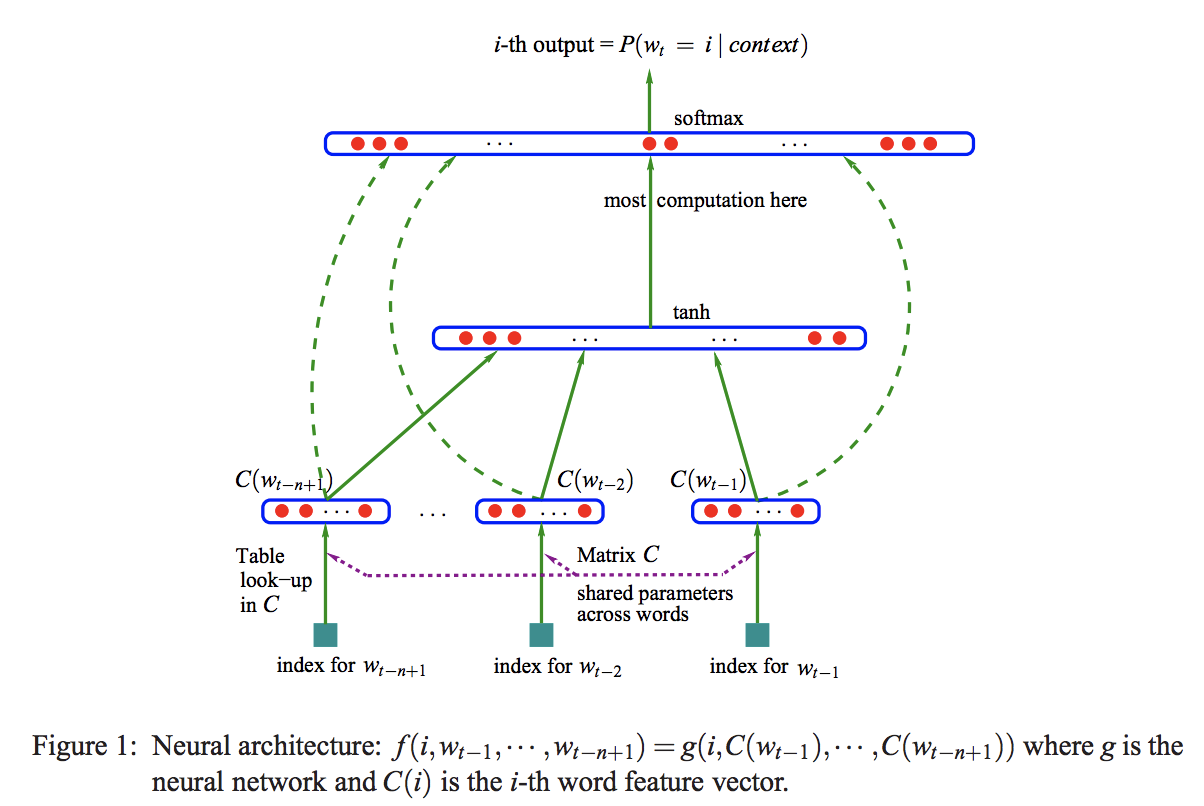

In [131]:
display.Image('imgs/mlp_language_model.png') # Show the network structure

In [132]:
# Create the look up table, suppose the embedding space is n-dimensional
# then the size of the lookup table is [27, n] (n components for 27 inputs)
emb_dim = 10
lookup = torch.randn((char_num, emb_dim))

In [133]:
# Look up the table using the tensor xs to represent xs by the embedding vectors
# For each samples, there are 'windows_size' chars, each chars are represented by a nd vector
# Thus for each sample, the dimension is windows_size x n
# There are totally 228146 samples in the dataset, then the shape of the tensor is 228146 x 3 x 2
emb = lookup[xs]
emb.shape

torch.Size([228146, 3, 10])

##### Initialize the weight and bias in the beginning is essential for a good training performance, since extrem values in the initial distribution can be elimated

In [134]:
# Set generator seed and initalize parameters
# Notice that the input tensor is [228146, 3, 2], so we concentate the last two dimensions for input
# The input tensor will be [228146, 6], this is why the input dimension of the first layer is 6
neuron_num = 200
g = torch.Generator().manual_seed(84822937)

# Initalize parameters
W1 = torch.randn(window_size * emb_dim, neuron_num, generator=g)
b1 = torch.randn(neuron_num,                        generator=g)
W2 = torch.randn(neuron_num, char_num,              generator=g) * 0.01
b2 = torch.randn(char_num,                          generator=g) * 0
params = [lookup, W1, b1, W2, b2]

# Sum up the number of parameters
print("Total number of parameters: {}".format(sum(p.nelement() for p in params)))

# Set all parameters to be trainable
for p in params:
    p.requires_grad = True

Total number of parameters: 11897


In [135]:
# Train the network
def train(x, y, epoch, lr, is_batch=False, batch_size=32, track=False, record=False):
    """ train the network """
    stepi, lossi = [], []

    for k in range(epoch):
        # Training batch construct
        if is_batch:
            batch_idx = torch.randint(0, x.shape[0], (batch_size,))  # Get batch index 
            batch_emb = lookup[x[batch_idx]]    # Only use select samples as a batch for training
            target = y[batch_idx]               # The corresponding targets for training
        else: 
            batch_emb = lookup[x]               # Use the whole dataset for training
            target = y

        # forward
        h = torch.tanh(batch_emb.view(batch_emb.shape[0], -1) @ W1 + b1) # The hidden layer output
        logits = h @ W2 + b2

        # loss 
        loss = F.cross_entropy(logits, target)
        if record:
            stepi.append(k)
            lossi.append(loss.log10().item())
        if track:
            if k % 10000 == 0:
                print(f'{k:7d}/{epoch:7d}: {loss.item():.4f}')

        # Backward
        for p in params:
            p.grad = None
        loss.backward()

        # Update
        for p in params:
            p.data += -lr * p.grad
        
    return stepi, lossi
    

In [136]:
step, loss = train(x_tr, y_tr, epoch=200000, lr=0.01, is_batch=True, track=True, record=True)

      0/ 200000: 3.2925
  10000/ 200000: 2.2159
  20000/ 200000: 2.5928
  30000/ 200000: 2.1875
  40000/ 200000: 2.2046
  50000/ 200000: 2.2240
  60000/ 200000: 2.3681
  70000/ 200000: 2.2917
  80000/ 200000: 2.4142
  90000/ 200000: 2.1396
 100000/ 200000: 1.9017
 110000/ 200000: 2.3931
 120000/ 200000: 2.1017
 130000/ 200000: 2.0167
 140000/ 200000: 2.2747
 150000/ 200000: 1.9555
 160000/ 200000: 2.3648
 170000/ 200000: 2.0130
 180000/ 200000: 1.9918
 190000/ 200000: 2.3050


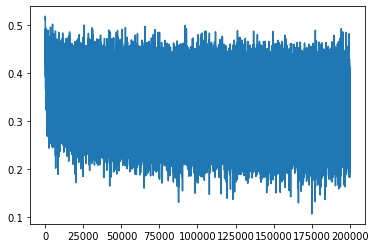

In [137]:
# After a good initalization, the error region is squeezing enabling a better training result
plt.plot(step, loss)

In [138]:
def evaluate(x, y, C):
    """
    Validate and test the trained network, and return the loss
    x: the given input
    y: the expected output
    C: the lookup table for embedding
    """

    emb = C[x]
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, y).item()
    

In [139]:
# Use the valid set to see whether the model is overfitting
print(f'loss on valid set is {evaluate(x_va, y_va, lookup):.4f}')
# Test on the test set
print(f'loss on test set is {evaluate(x_te, y_te, lookup):.4f}')

loss on valid set is 2.1861
loss on test set is 2.1739


In [140]:
neuron_num = 200
g = torch.Generator().manual_seed(84822935)

# Initalize parameters
# b2 will be initalized by all 0 to eliminate randomness
# W2 will be set to a small initial number to avoid extrem values in the weight matrix
W1 = torch.randn(window_size * emb_dim, neuron_num, generator=g)
b1 = torch.randn(neuron_num,                        generator=g)
W2 = torch.randn(neuron_num, char_num,              generator=g) * 0.01
b2 = torch.randn(char_num,                          generator=g) * 0
params = [lookup, W1, b1, W2, b2]

# Sum up the number of parameters
print("Total number of parameters: {}".format(sum(p.nelement() for p in params)))

# Set all parameters to be trainable
for p in params:
    p.requires_grad = True

Total number of parameters: 11897


In [141]:
batch_idx = torch.randint(0, x_tr.shape[0], (32,))  # Get batch index 
batch_emb = lookup[x_tr[batch_idx]]    # Only use select samples as a batch for training
target = y_tr[batch_idx]               # The corresponding targets for training

h_preact = batch_emb.view(batch_emb.shape[0], -1) @ W1 + b1
h = torch.tanh(h_preact)
logits = h @ W2 + b2

# loss 
loss = F.cross_entropy(logits, target)

# Backward
for p in params:
    p.grad = None
loss.backward()

# Update
for p in params:
    p.data += -0.01 * p.grad

In [142]:
# There are so many 1 and -1 in the tensor h
h

tensor([[-0.9998,  1.0000,  0.9993,  ...,  0.9882, -1.0000, -0.9998],
        [-0.9979,  0.9998,  0.9999,  ..., -0.9970,  0.7491,  1.0000],
        [-0.8448, -0.3782,  0.9531,  ..., -0.9774, -1.0000,  0.6254],
        ...,
        [ 0.9998, -1.0000,  0.7682,  ...,  0.9990, -0.6754, -0.9998],
        [-1.0000, -1.0000,  0.9848,  ..., -0.3688,  1.0000,  0.1433],
        [-0.8369, -1.0000,  1.0000,  ...,  0.8378, -0.9811,  0.9989]],
       grad_fn=<TanhBackward0>)

Text(0.5, 1.0, 'hidden layer value distribution after activation')

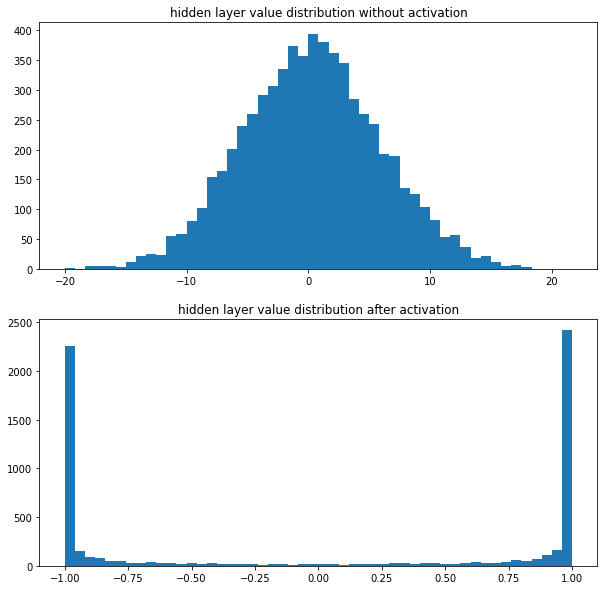

In [143]:
plt.figure(1, figsize=(10, 10))
plt.subplot(211)
plt.hist(h_preact.view(-1).tolist(), 50);
plt.title("hidden layer value distribution without activation")
plt.subplot(212)
plt.hist(h.view(-1).tolist(), 50);
plt.title("hidden layer value distribution after activation")

##### Ues the tanh, the derivative of the tanh = (1 - x^2) * p.grad will be vanished when the x is closed to +1 or -1,and it is hard to train the network with this nearly 0 gradient, thus the value distribution (as shown in the sub figure below) after activation is not good for network training. While, if x is closed to 0, the gradient can then be maintained.

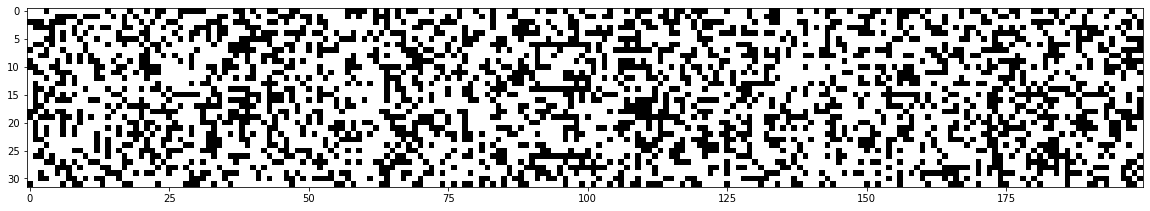

In [144]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

##### The x-axis is the index each neuron, the y-axis is the index of each batch. A white color at a pixel (i, j) means the neuron i can learn nothing on the batch sample j, thus if a totally while column means the neuron learns nothin from this batch, or the neuron is called 'dead neuron'. Thus to promise a good backward result, the initialized weight should be shrinked to avoid the activation saturated too much

In [145]:
neuron_num = 200
g = torch.Generator().manual_seed(84822934)

# Initalize parameters
# b2 will be initalized by all 0 to eliminate randomness
# W2 will be set to a small initial number to avoid extrem values in the weight matrix
# b1 is set to 0, and W1 is multiple by 0.1 to shrink the range of the value distribution
W1 = torch.randn(window_size * emb_dim, neuron_num, generator=g) * 0.2
b1 = torch.randn(neuron_num,                        generator=g) * 0.01
W2 = torch.randn(neuron_num, char_num,              generator=g) * 0.01
b2 = torch.randn(char_num,                          generator=g) * 0
params = [lookup, W1, b1, W2, b2]

# Sum up the number of parameters
print("Total number of parameters: {}".format(sum(p.nelement() for p in params)))

# Set all parameters to be trainable
for p in params:
    p.requires_grad = True

Total number of parameters: 11897


In [146]:
batch_idx = torch.randint(0, x_tr.shape[0], (32,))  # Get batch index 
batch_emb = lookup[x_tr[batch_idx]]    # Only use select samples as a batch for training
target = y_tr[batch_idx]               # The corresponding targets for training

h_preact = batch_emb.view(batch_emb.shape[0], -1) @ W1 + b1
h = torch.tanh(h_preact)
logits = h @ W2 + b2

# loss 
loss = F.cross_entropy(logits, target)

# Backward
for p in params:
    p.grad = None
loss.backward()

# Update
for p in params:
    p.data += -0.01 * p.grad

Text(0.5, 1.0, 'hidden layer value distribution after activation')

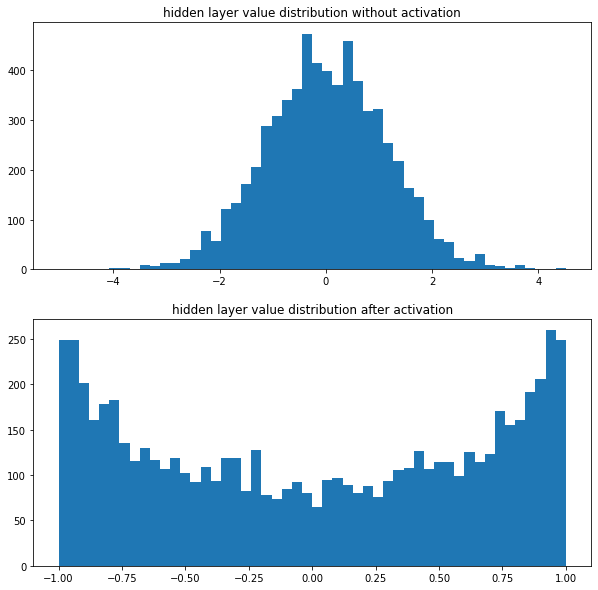

In [147]:
plt.figure(1, figsize=(10, 10))
plt.subplot(211)
plt.hist(h_preact.view(-1).tolist(), 50);
plt.title("hidden layer value distribution without activation")
plt.subplot(212)
plt.hist(h.view(-1).tolist(), 50);
plt.title("hidden layer value distribution after activation")

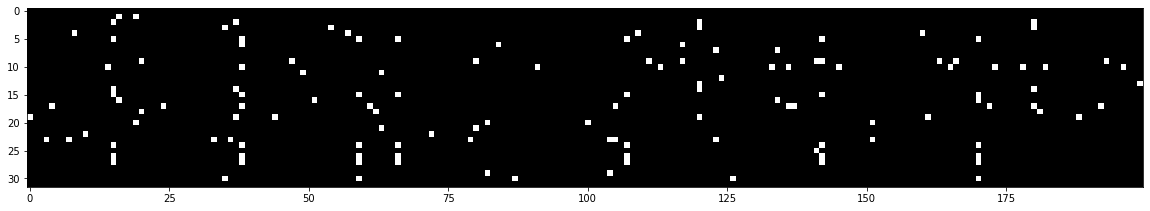

In [148]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

##### After modification and set limitation to the range of initial values, all neurons can now learn something since all values can now not saturated to 1 or -1

In [149]:
# Now use the Kaiming_init value to normalize the initial weight W1 
kaiming_init = (5/3) / ((emb_dim * window_size) ** 0.5)

In [150]:
neuron_num = 200
g = torch.Generator().manual_seed(84822933)

# Initalize parameters
# b2 will be initalized by all 0 to eliminate randomness
# W2 will be set to a small initial number to avoid extrem values in the weight matrix
# b1 is set to 0, and W1 is multiple by 0.1 to shrink the range of the value distribution
W1 = torch.randn(window_size * emb_dim, neuron_num, generator=g) * kaiming_init
b1 = torch.randn(neuron_num,                        generator=g) * 0.01
W2 = torch.randn(neuron_num, char_num,              generator=g) * 0.01
b2 = torch.randn(char_num,                          generator=g) * 0
params = [lookup, W1, b1, W2, b2]

# Sum up the number of parameters
print("Total number of parameters: {}".format(sum(p.nelement() for p in params)))

# Set all parameters to be trainable
for p in params:
    p.requires_grad = True

Total number of parameters: 11897


In [151]:
# Train the network
lr = 0.01
epoch = 200000
batch_size = 32
stepi, lossi = [], []

for k in range(epoch):
    # Training batch construct
    batch_idx = torch.randint(0, x_tr.shape[0], (batch_size,))  # Get batch index 
    batch_emb = lookup[x_tr[batch_idx]]    # Only use select samples as a batch for training
    target = y_tr[batch_idx]               # The corresponding targets for training

    # forward
    h_preact = batch_emb.view(batch_emb.shape[0], -1) @ W1 + b1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2

    # loss 
    loss = F.cross_entropy(logits, target)
    
    stepi.append(k)
    lossi.append(loss.log10().item())
    
    if k % 10000 == 0:
        print(f'{k:7d}/{epoch:7d}: {loss.item():.4f}')

    # Backward
    for p in params:
        p.grad = None
    loss.backward()

    # Update
    for p in params:
        p.data += -lr * p.grad

      0/ 200000: 3.3212
  10000/ 200000: 2.2564
  20000/ 200000: 2.4187
  30000/ 200000: 2.2895
  40000/ 200000: 2.0279
  50000/ 200000: 2.1916
  60000/ 200000: 2.0924
  70000/ 200000: 1.8707
  80000/ 200000: 1.8778
  90000/ 200000: 2.1184
 100000/ 200000: 2.4467
 110000/ 200000: 2.2119
 120000/ 200000: 2.3450
 130000/ 200000: 2.3025
 140000/ 200000: 2.1500
 150000/ 200000: 1.9649
 160000/ 200000: 2.0429
 170000/ 200000: 2.0349
 180000/ 200000: 2.1118
 190000/ 200000: 2.3796


In [152]:
# Use the valid set to see whether the model is overfitting
print(f'loss on valid set is {evaluate(x_va, y_va, lookup):.4f}')
# Test on the test set
print(f'loss on test set is {evaluate(x_te, y_te, lookup):.4f}')

loss on valid set is 2.1521
loss on test set is 2.1367


In [153]:
sample_g = torch.Generator().manual_seed(34568789)

# Generate new name from the trained model
def sample(gen_num):

    for i in range(gen_num):
        gen_str = []
        context = [0] * window_size

        while True:
            emb_gen = lookup[torch.tensor(context)] # The size of the tensor (1, ws, emb_dim)

            # Generate (predict) by forwarding to the network with trained parameters
            h = torch.tanh(emb_gen.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2

            # An array of probability for each char in prediction
            probs = F.softmax(logits, dim=1) 

            # Get the idx with greatest probability to be the next char
            idx = torch.multinomial(probs, num_samples=1, generator=sample_g).item()
            
            if idx != 0:
                context = context[1:] + [idx]
                gen_str.append(itos[idx])
            else:
                break
        
        # Print each name
        print(''.join(gen_str))


In [154]:
sample(20)

zrie
nayden
johalen
amrektymica
tamaelynn
america
jadilla
sia
blo
ver
quinust
zah
deotaged
mam
esriersarayah
ana
fah
ashtyn
lary
ghoure
